In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


In [12]:
## Read raw data
df = pd.read_csv("temp-data.csv")

data = df.to_numpy()
Toriginal = data[:,1]
t = data[:,0]

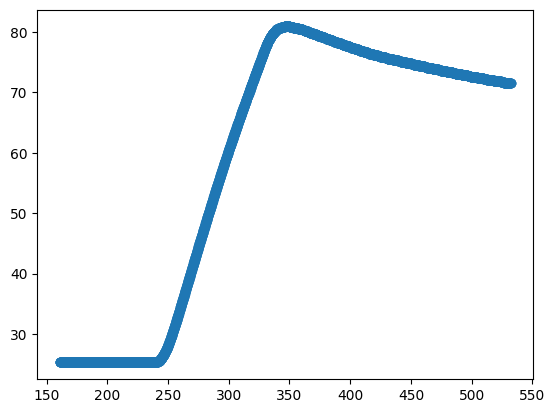

In [7]:
## Plot original data
axs = plt.subplots()
plt.scatter(data[:,0], data[:,1])

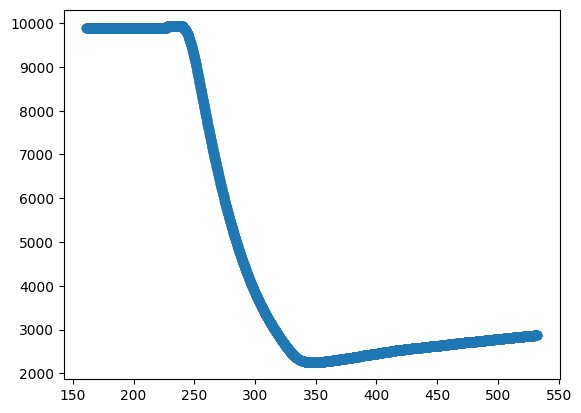

In [10]:
## convert data back to ADC readings
# Constants
kVref = 30000
kRpu = 20000
kTn = 298.15
kTk = 273.15
kBeta = 3435
kRtn = 10000
kNumRetries = 3
kNumSamples = data.shape[0]

ADCoriginal = kVref * np.divide(1, np.divide(1, kRtn * np.exp(kBeta*(np.divide(1, data[:,1] + kTk) - 1/kTn)))*kRpu + 1)

# Plot Original ADC data
axs = plt.subplots()
plt.scatter(data[:,0], ADCoriginal)

In [124]:
## Max difference bwteen samples

ADC_sample_diff = np.zeros(ADCoriginal.shape)

for i in range(1, ADCoriginal.shape[0]):
    ADC_sample_diff[i] = np.abs(ADCoriginal[i] - ADCoriginal[i-1])

# axs = plt.subplots()
# plt.scatter(data[:,0], ADC_sample_diff)

print(np.max(ADC_sample_diff))

25.584303827732583


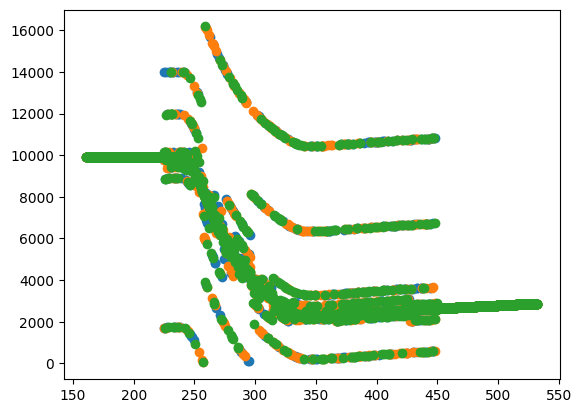

In [183]:
## Induce noise in data

# Triple the number of ADC points
ADCnoise = np.uint16(np.array([ADCoriginal,ADCoriginal,ADCoriginal]))


# Random noise
use_seed = True

if use_seed:
    rng = np.random.default_rng(seed = 42)
else:
    rng = np.random.default_rng(12345)

kMaxBitFlips = 1

number_of_bit_flips = rng.integers(low = 1, high = kMaxBitFlips+1, size=(kNumRetries, kNumSamples))
bit_flip_location = rng.integers(low = 0, high = 16, size=(kNumRetries, kNumSamples, kMaxBitFlips))
bit_flip_value = rng.integers(low = 0, high = 2, size=(kNumRetries, kNumSamples, kMaxBitFlips))

for i in range(0, ADCnoise.shape[0]):
    for j in range(0, ADCnoise.shape[1]):
        if t[j] > 225 and t[j] < 450:
            for k in range(0, number_of_bit_flips[i,j]):
                ADCnoise[i,j] = ADCnoise[i,j] ^ (bit_flip_value[i,j,k] << bit_flip_location[i,j,k])

ADCnoise = ADCnoise & 0x3FFF

# Plot ADC noise
axs = plt.subplots()
plt.scatter(t, ADCnoise[0,:])
plt.scatter(t, ADCnoise[1,:])
plt.scatter(t, ADCnoise[2,:])

In [184]:
## Generate abs difference matrix
ADCbar = np.mean(ADCnoise, axis=0)

# Measure
ADCdiff = np.zeros((kNumRetries, kNumSamples))

ADCdiff[0,:] = np.abs(ADCnoise[0, :] - ADCbar)
ADCdiff[1,:] = np.abs(ADCnoise[1, :] - ADCbar)
ADCdiff[2,:] = np.abs(ADCnoise[2, :] - ADCbar)

In [191]:
## Generate results
ADCgood_flag = ADCdiff > 100

ADCans = np.zeros(kNumSamples)
ADCrejects = np.zeros(kNumSamples)

good_vals = 0
total = 0

kActivateBand = False

for i in range(1, kNumSamples):
    for k in range(0,kNumRetries):
        if(ADCgood_flag[k,i]):
            if kActivateBand and (np.abs(ADCnoise[k, i] - ADCnoise[k, i-1]) < 50):
                good_vals += 1
                total += ADCnoise[k,i]
            elif not kActivateBand:
                good_vals += 1
                total += ADCnoise[k,i]
    if (good_vals != 0):
        ADCans[i] = np.uint16(total/good_vals) & 0x7FFF
    else:
        ADCans[i] = np.NaN
    ADCrejects[i] = kNumRetries-good_vals
    good_vals = 0
    total = 0



Tans = np.divide(1, (np.log(np.divide(np.divide(20000, (30000/ADCans - 1)), 10000)) / 3435) + 1/298.15) - 273.15

C:\Users\Marco.Nunez\AppData\Local\Temp\ipykernel_1848\2168745318.py:31: RuntimeWarning: divide by zero encountered in divide
  Tans = np.divide(1, (np.log(np.divide(np.divide(20000, (30000/ADCans - 1)), 10000)) / 3435) + 1/298.15) - 273.15
C:\Users\Marco.Nunez\AppData\Local\Temp\ipykernel_1848\2168745318.py:31: RuntimeWarning: divide by zero encountered in log
  Tans = np.divide(1, (np.log(np.divide(np.divide(20000, (30000/ADCans - 1)), 10000)) / 3435) + 1/298.15) - 273.15


In [192]:
## Remove hot values
for i in range(1, Tans.shape[0]):
    if Tans[i] > 100:
        Tans[i] = Tans[i-1]

In [193]:
## Count NaNs
ADCnans = 0
nan_values = 0

for j in range(0, kNumSamples):
    if(np.isnan(ADCans[j])):
        nan_values += 1
    
ADCnans = nan_values

print(ADCnans)

2665


In [194]:
## Rejects per bit
# Average
ADCreject_mean = np.mean(ADCrejects)
# Max
ADCreject_max = np.max(ADCrejects)
# Min
ADCreject_min = np.min(ADCrejects)

print("Mean Reject samples: " + str(ADCreject_mean))
print("Max Reject samples: " + str(ADCreject_max))
print("Min Reject samples: " + str(ADCreject_min))

Mean Reject samples: 2.2410449771074603
Max Reject samples: 3.0
Min Reject samples: 0.0


In [195]:
## Apply Filter
kInitTemp = 25
lam = [0.01, 0.03, 0.05]
# lam = [0.002, 0.01, 0.03, 0.05, 0.1]
Tfiltered = np.ones((kNumSamples, len(lam))) * kInitTemp

for j in range(0, Tfiltered.shape[1]):
    for i in range(1, kNumSamples):
        if (np.isnan(Tans[i])):
            Tfiltered[i, j] = Tfiltered[i-1, j]
        else:
            Tfiltered[i, j] = lam[j] * Tans[i] + (1 - lam[j]) * Tfiltered[i-1, j]

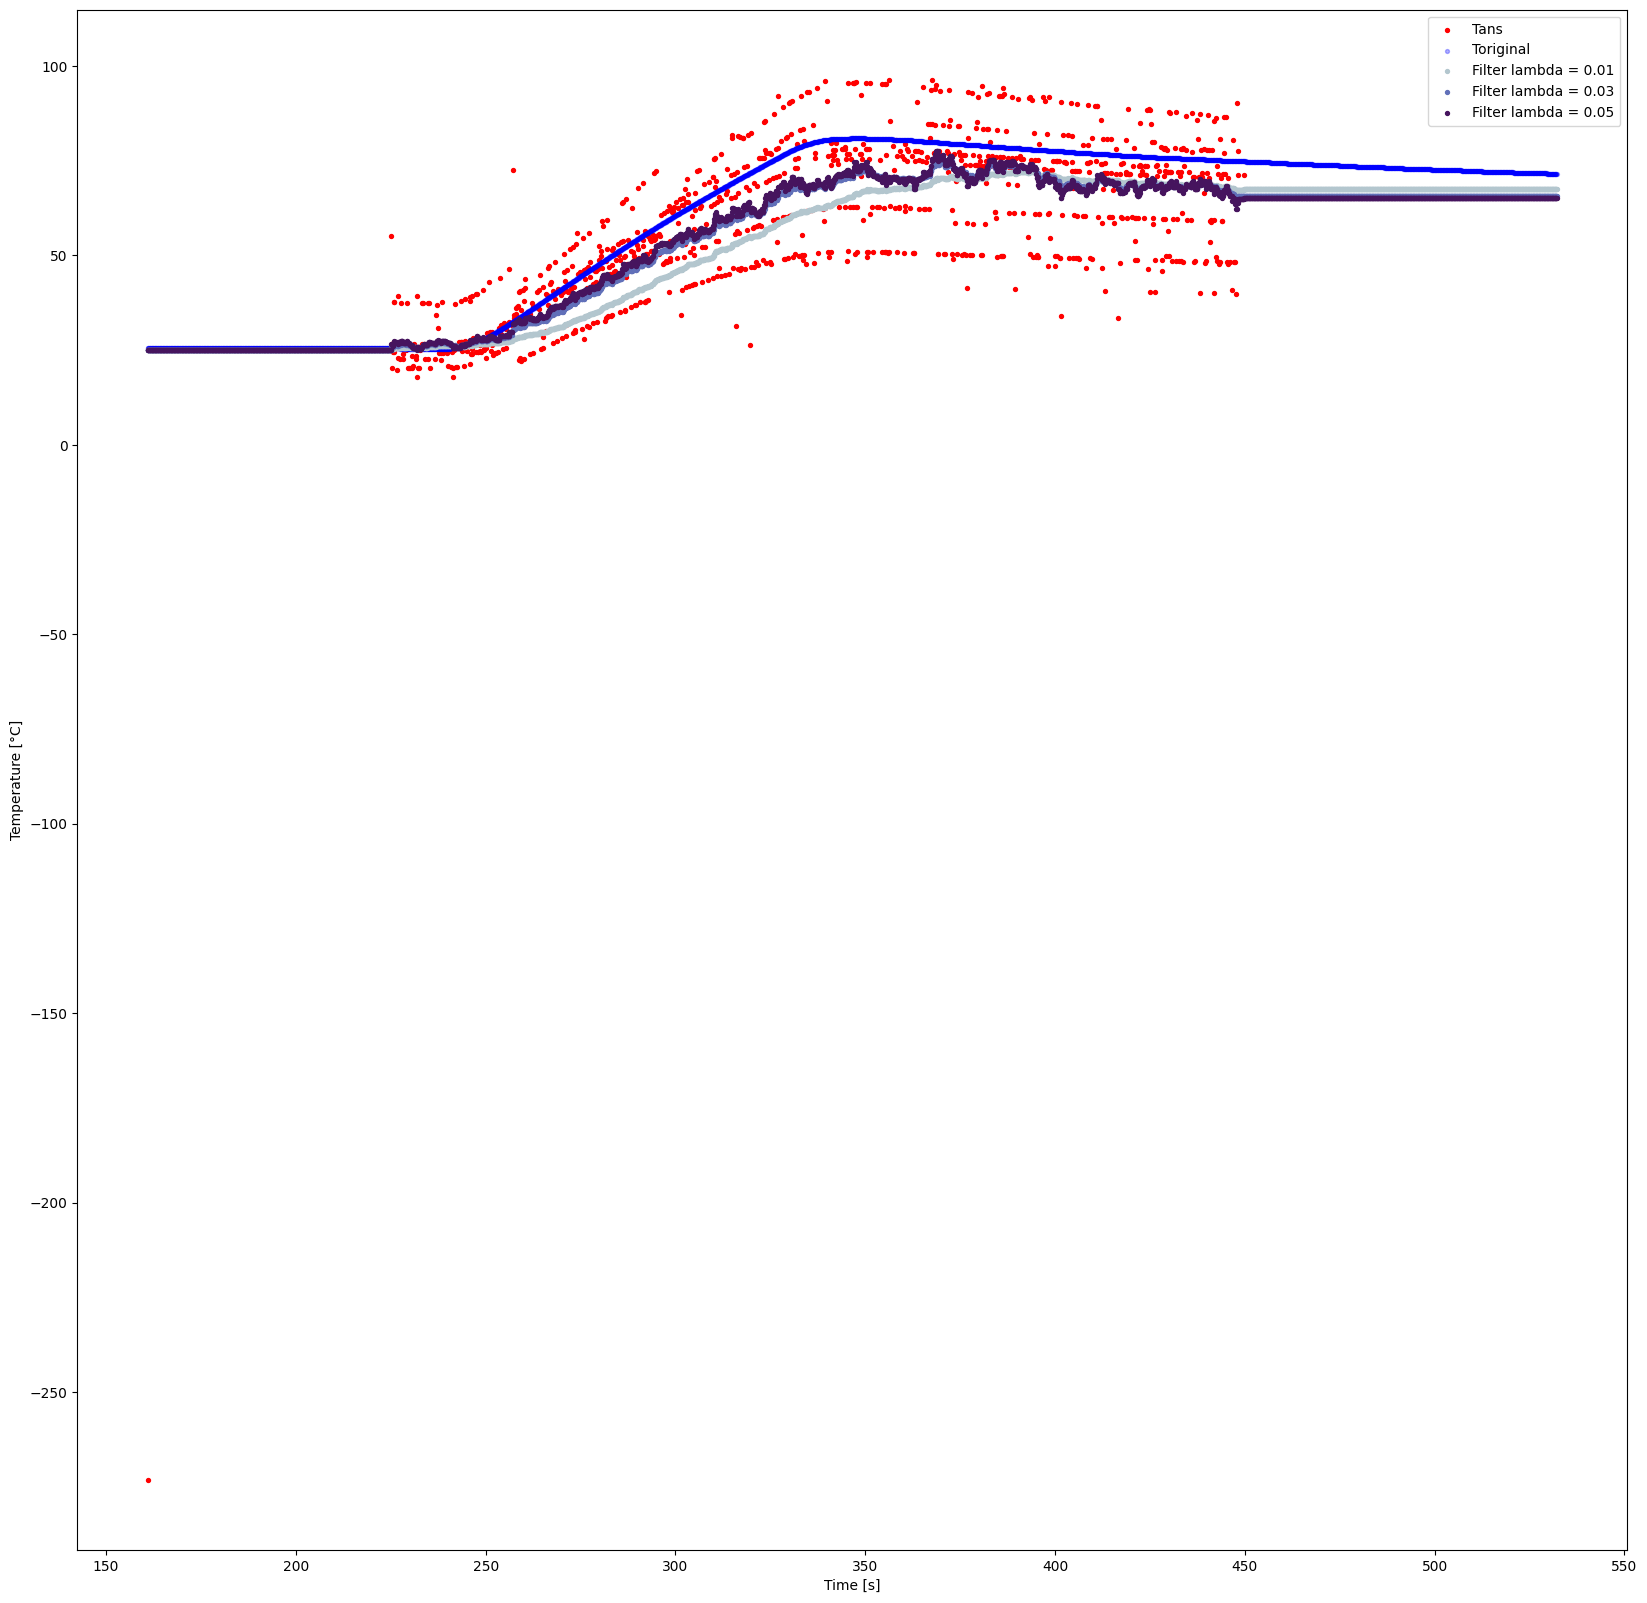

In [196]:
## Plot of Processed Data
fig, axs = plt.subplots(figsize=(20, 20))
colormap = mpl.colormaps['twilight'].resampled(120)
c = colormap(np.linspace(0,1,24))

plt.scatter(t, Tans, s=8, color='r', alpha=1)
plt.scatter(t, Toriginal, s=8, color='b', alpha=0.3)

leg = ["Tans", "Toriginal"]
for i in range(0, Tfiltered.shape[1]):
    plt.scatter(t, Tfiltered[:,i], s=8, color=c[4*i+2])
    leg_name = "Filter lambda = " + str(lam[i])
    leg.append(leg_name)

plt.xlabel("Time [s]")
plt.ylabel("Temperature [°C]")


plt.legend(leg, loc='best')